<a href="https://colab.research.google.com/github/isaacmenchaca97/breast_cancer_detection/blob/main/breast_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -r requirements.txt

In [ ]:
# Data preparation
# ========================================================================
import pandas as pd
import numpy as np
from scipy import stats

# Graph
# ========================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import plotly.express as px
plt.style.use('ggplot')

# MLFlow
# ========================================================================
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

# Sklearn
# ========================================================================
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Model Performance Evaluators
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

##### Loading the data

In [ ]:
data = load_breast_cancer()
df = pd.DataFrame(data=data.data, columns=data.feature_names)
df['target'] = data.target
df.columns = df.columns.str.lower().str.replace(" ", "_")
df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


##### Exploratory Data Analysis aka EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean_radius              569 non-null    float64
 1   mean_texture             569 non-null    float64
 2   mean_perimeter           569 non-null    float64
 3   mean_area                569 non-null    float64
 4   mean_smoothness          569 non-null    float64
 5   mean_compactness         569 non-null    float64
 6   mean_concavity           569 non-null    float64
 7   mean_concave_points      569 non-null    float64
 8   mean_symmetry            569 non-null    float64
 9   mean_fractal_dimension   569 non-null    float64
 10  radius_error             569 non-null    float64
 11  texture_error            569 non-null    float64
 12  perimeter_error          569 non-null    float64
 13  area_error               569 non-null    float64
 14  smoothness_error         5

In [ ]:
df.dtypes.value_counts()

,count
float64,30
int64,1


In [ ]:
df[df.columns].describe().T

,count,mean,std,min,25%,50%,75%,max
mean_radius,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
mean_texture,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
mean_perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
mean_area,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
mean_smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
mean_compactness,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
mean_concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
mean_concave_points,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
mean_symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
mean_fractal_dimension,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


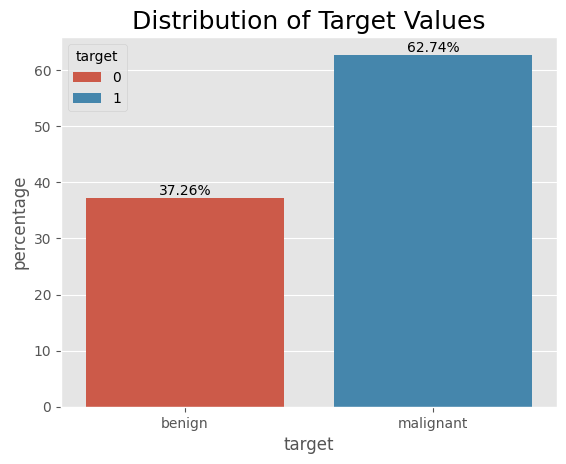

In [ ]:
value_counts_df = (round(df.target.value_counts(normalize=True)*100,2)).reset_index()
value_counts_df.columns = ['target', 'percentage']
ax = sns.barplot(x=value_counts_df['target'], y=value_counts_df['percentage'], hue=value_counts_df['target'], dodge=False)
ax.bar_label(ax.containers[0], fmt="%.2f%%")
ax.bar_label(ax.containers[1],fmt="%.2f%%")
plt.xticks(ticks=[0,1], labels=['benign', 'malignant'])
plt.title('Distribution of Target Values', fontsize=18)
plt.show()

In [ ]:
num_cols = list(df.select_dtypes('float64').columns)
unrelated_num_cols = []
categorical_col = 'target'

for i in num_cols:
    # Perform Kruskal-Wallis test
    grouped_data = [df[i][df[categorical_col] == category] for category in df[categorical_col].unique()]
    statistic, p_value = stats.f_oneway(*grouped_data)

    # Set the significance level (alpha)
    alpha = 0.05

    # Print the results with appropriate text color
    if p_value < alpha:
        print( f"ANOVA statistic: {round(statistic, 2)}")
        print(f"p-value: {p_value:.2e}")
        print("\033[32m" + f"Reject the null hypothesis: There is a significant relationship between {i} and {categorical_col}")
        print("\033[0m")  # Reset text color to default
    else:
        print( f"ANOVA statistic: {round(statistic, 2)}")
        print(f"p-value: {p_value:.2e}")
        print("\033[31m" + f"No significant relationship between {i} and {categorical_col}")
        print("\033[0m")  # Reset text color to default
        unrelated_num_cols.append(i)

ANOVA statistic: 646.98
p-value: 8.47e-96
Reject the null hypothesis: There is a significant relationship between mean_radius and target

ANOVA statistic: 118.1
p-value: 4.06e-25
Reject the null hypothesis: There is a significant relationship between mean_texture and target

ANOVA statistic: 697.24
p-value: 8.44e-101
Reject the null hypothesis: There is a significant relationship between mean_perimeter and target

ANOVA statistic: 573.06
p-value: 4.73e-88
Reject the null hypothesis: There is a significant relationship between mean_area and target

ANOVA statistic: 83.65
p-value: 1.05e-18
Reject the null hypothesis: There is a significant relationship between mean_smoothness and target

ANOVA statistic: 313.23
p-value: 3.94e-56
Reject the null hypothesis: There is a significant relationship between mean_compactness and target

ANOVA statistic: 533.79
p-value: 9.97e-84
Reject the null hypothesis: There is a significant relationship between mean_concavity and target

ANOVA statistic: 861.

In [ ]:
print(f'The columns that failed the ANOVA test are {unrelated_num_cols}. These columns don\'t help in making predictions.')

The columns that failed the ANOVA test are ['mean_fractal_dimension', 'texture_error', 'smoothness_error', 'symmetry_error', 'fractal_dimension_error']. These columns don't help in making predictions.


##### Data Pre-processing

In [ ]:
df.drop(labels=unrelated_num_cols, axis=1, inplace=True)
df.columns

Index(['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area',
       'mean_smoothness', 'mean_compactness', 'mean_concavity',
       'mean_concave_points', 'mean_symmetry', 'radius_error',
       'perimeter_error', 'area_error', 'compactness_error', 'concavity_error',
       'concave_points_error', 'worst_radius', 'worst_texture',
       'worst_perimeter', 'worst_area', 'worst_smoothness',
       'worst_compactness', 'worst_concavity', 'worst_concave_points',
       'worst_symmetry', 'worst_fractal_dimension', 'target'],
      dtype='object')

In [ ]:
X = df.drop(columns=['target'])
X.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,radius_error,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,1.0950,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.5435,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.7456,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.4956,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.7572,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
y = df['target']
y.head()

,target
0,0
1,0
2,0
3,0
4,0


In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

##### Principal Component Analysis (PCA)

In [ ]:
model_pca = PCA()
proyections = model_pca.fit_transform(X_scaled)

In [ ]:
prop_varianza_acum = model_pca.explained_variance_ratio_.cumsum()
n_pca = 0
for i in range(model_pca.n_components_):
    if prop_varianza_acum[i]*100 < 92:
        n_pca += 1
        print(f'At {n_pca} PC, Explained Variance is {round(prop_varianza_acum[i]*100,2)}%')

At 1 PC, Explained Variance is 59.5%
At 2 PC, Explained Variance is 74.83%
At 3 PC, Explained Variance is 82.28%
At 4 PC, Explained Variance is 87.3%
At 5 PC, Explained Variance is 90.77%


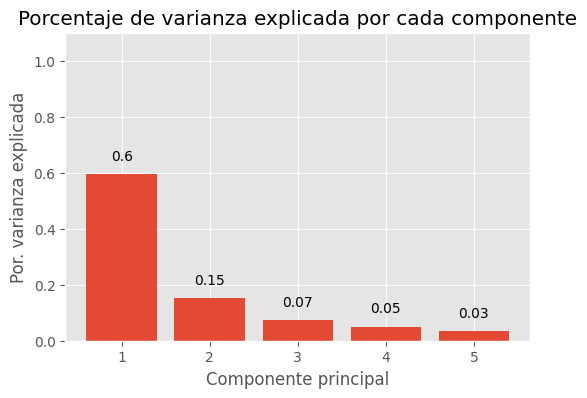

In [ ]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(n_pca) + 1,
    height = model_pca.explained_variance_ratio_[:n_pca],
)

for x, y_axis in zip(np.arange(n_pca) + 1, model_pca.explained_variance_ratio_[:n_pca]):
    label = round(y_axis, 2)
    ax.annotate(
        label,
        (x,y_axis),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(n_pca) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');


[0.59501941 0.74834484 0.82281042 0.87302617 0.90773815 0.93463044
 0.94988493 0.96079605 0.97080502 0.97756904 0.98223264 0.98576041
 0.98901659 0.99175811 0.99406284 0.99597394 0.99714047 0.99808642
 0.99874701 0.99923814 0.99963744 0.99989128 0.99995833 0.99999314
 1.        ]


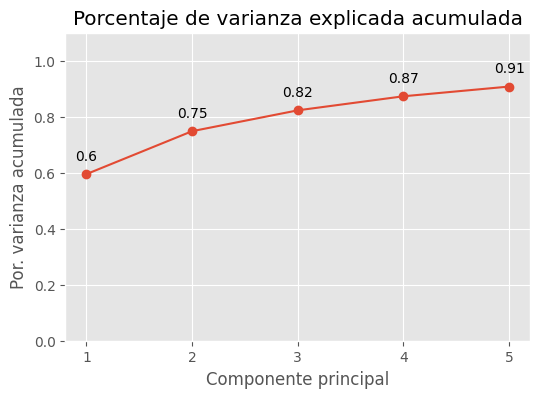

In [ ]:
prop_varianza_acum = model_pca.explained_variance_ratio_.cumsum()
print(prop_varianza_acum)

n_pca = 0
for i in range(model_pca.n_components_):
    if prop_varianza_acum[i]*100 < 92:
        n_pca += 1

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(n_pca) + 1,
    prop_varianza_acum[:n_pca],
    marker = 'o'
)

for x, y_axis in zip(np.arange(n_pca) + 1, prop_varianza_acum[:n_pca]):
    label = round(y_axis, 2)
    ax.annotate(
        label,
        (x,y_axis),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(n_pca) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');


##### Transformation

In [ ]:
new_df = pd.DataFrame(
    proyections[:, :n_pca],
    columns=[f"PC{i+1}" for i in range(n_pca)],
    index= df.index
)
new_df['Target'] = df['target']
new_df.head()

,PC1,PC2,PC3,PC4,PC5,Target
0,1.366068,0.350787,-0.530171,0.115811,-0.030560,0
1,0.475382,-0.516408,-0.144308,0.132492,-0.128261,0
2,0.958013,-0.058981,-0.124824,0.041662,0.024654,0
3,0.943124,1.328115,0.019260,0.244501,0.019175,0
4,0.633546,-0.318726,-0.439484,-0.036891,-0.010713,0
...,...,...,...,...,...,...
564,1.016546,-0.462586,-0.182919,-0.101769,0.187568,0
565,0.635697,-0.499501,0.278995,-0.090260,0.152983,0
566,0.235868,-0.235184,0.321758,-0.216395,-0.057019,0
567,1.667126,0.365569,0.305252,-0.040297,-0.048841,0


##### Handling class imbalance

In [ ]:
label, counts = np.unique(y, return_counts=True)
print(f"label: {label}\ncounts: {counts}")
# compute the class weights
counts = max(counts) / counts
class_weights = dict(zip(label, np.around(counts,3)))
print('=== CLASS WEIGHTS ===')
print(class_weights)

label: [0 1]
counts: [212 357]
=== CLASS WEIGHTS ===
{0: 1.684, 1: 1.0}


##### Splitting data and training models

In [ ]:
X_pca = new_df.drop(columns=['Target'])
y_pca = new_df['Target']

#Splitting the data into train and validation set
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_pca, test_size=0.20, random_state=42)


In [ ]:
#Creating a list of classifier models
names = ['Logistic Regression', "KNN", "Linear SVM","Gradient Boosting", "Decision Tree", "Random Forest"]
classifiers = [
    LogisticRegression(solver='liblinear', class_weight=class_weights, random_state=42),
    KNeighborsClassifier(n_neighbors=3, weights= 'distance'),
    SVC(kernel="linear", C=0.025, class_weight=class_weights, random_state=42),
    GradientBoostingClassifier(n_estimators=100, random_state=42),
    DecisionTreeClassifier(max_depth=5, class_weight=class_weights, random_state=42),
    RandomForestClassifier(max_depth=5, n_estimators=100, class_weight=class_weights, random_state=42)
    ]

In [ ]:
# Define the number of folds for cross-validation
num_folds = 5  # You can adjust this as needed

# Initialize an empty list to store scores
scores = []

for name, clf in zip(names, classifiers):
    # Perform k-fold cross-validation and calculate the mean score
    cv_scores = cross_val_score(clf, X_train, y_train, cv=num_folds)
    mean_score = np.mean(cv_scores)
    scores.append(mean_score)

# Create a DataFrame to store the results
scores_df = pd.DataFrame()
scores_df['Name'] = names
scores_df['CV Mean score'] = np.around(scores, 3)

# Sort the DataFrame by score in descending order
sorted_scores_df = scores_df.sort_values('CV Mean score', ascending=False)
sorted_scores_df

,Name,CV Mean score
0,Logistic Regression,0.974
1,KNN,0.954
3,Gradient Boosting,0.954
5,Random Forest,0.947
2,Linear SVM,0.938
4,Decision Tree,0.916


##### Model accuracy and performance check

In [ ]:
#Initiating the model
model = LogisticRegression(solver='liblinear', random_state=42,  n_jobs=-1, class_weight=class_weights)

#fitting the model
model.fit(X_train, y_train)

#making the predictions
LRtrain_preds = model.predict(X_test)

#Creating the confusion matrix
confusionmatrix = np.around(confusion_matrix(y_test, LRtrain_preds, normalize='true'),3)

#Plotting the Confusion Matrix
fig = px.imshow(confusionmatrix, template='ggplot2',text_auto=True, aspect="auto",
                labels=dict(x="Predicted Label", y="Correct Label", color='Value'))
fig.update_xaxes(side="bottom")
fig.show()

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning:

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.



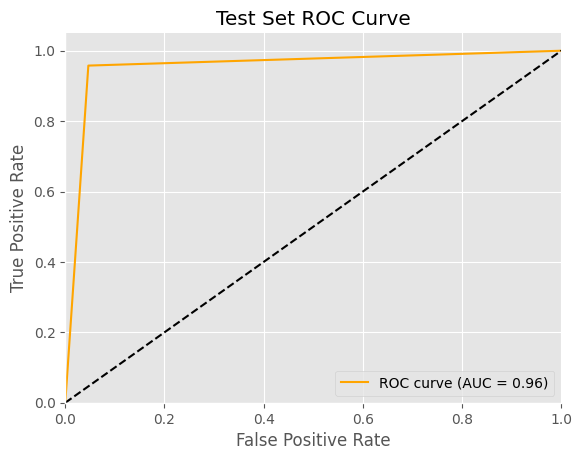

In [ ]:
# Assuming you have your model predictions and true labels
y_pred = model.predict(X_test)  # Replace with your model's predictions
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC (Area Under the ROC Curve)
auc = roc_auc_score(y_test, y_pred)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc), color='orange')
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(classification_report(y_test, LRtrain_preds))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94        43
           1       0.97      0.96      0.96        71

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



In [ ]:
misclassified_count = np.sum(y_test != LRtrain_preds)
total_cases = len(y_test)
error_rate = np.around((misclassified_count / total_cases) * 100, 3)

print(f"{misclassified_count} out of {total_cases} cases were misclassified, Error rate : {error_rate}%.")

5 out of 114 cases were misclassified, Error rate : 4.386%.
